In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import matplotlib.patches as mpatches
import os
import math
import random
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
#modified is the normal gtf without the first two lines below
# stringtie --merge 60541_transcripts.gtf 60542_transcripts.gtf 60543_transcripts.gtf 60544_transcripts.gtf 60545_transcripts.gtf 60546_transcripts.gtf 60547_transcripts.gtf 60548_transcripts.gtf -o afran_genome_annotation_0.5.gtf -F 0 -T 0.5
# StringTie version 2.2.1
fran_gtf=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/1.stringtie/afran_genome_annotation_0.5_2_modified.gtf",sep="\t",header=None)
fran_gtf_2=fran_gtf[[0,2,3,8]]
fran_gtf_2=fran_gtf_2[fran_gtf_2[2]=='transcript']
fran_gtf_2['gene_id']=fran_gtf_2[8].str.split(';',expand=True)[0]
fran_gtf_2=fran_gtf_2[[0,2,3,'gene_id']].drop_duplicates(subset='gene_id', keep="first")
fran_gtf_2['gene_id']=fran_gtf_2['gene_id'].str[9:-1]

In [4]:
seurat_clusters=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/seurat_clusters_cells_integrated_DUBStepR_3_2.txt",sep=",")

In [5]:
normalized_exp=pd.read_csv("/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/6.Integration/clean_run_04_12_2023/round_2/normalized_expression_DUBStepR_3_2.csv",sep=",",low_memory=False)

In [6]:
merged_normalized=pd.merge(normalized_exp,fran_gtf_2,left_on='gene',right_on='gene_id')

In [7]:
del normalized_exp

In [8]:
W_scaffolds=['scaffold000049W',
'scaffold000218W',
'scaffold000121W',
'scaffold000336W',
'scaffold000179W',
'scaffold000243W',
'scaffold000334W',
'scaffold000030W',
'scaffold000094W',
'scaffold000085W',
'scaffold000133W',
'scaffold000315W',
'scaffold000444W',
'scaffold000018W',
'scaffold000222W',
'scaffold000265W',
'scaffold000119W',
'scaffold000294W',
'scaffold000196W',
'scaffold000043W',
'scaffold000136W',
'scaffold000131W',
'scaffold000032W',
'scaffold000274W',
'scaffold000023W',
'scaffold000046W',
'scaffold000324W',
'scaffold000330W',
'scaffold000370W',
'scaffold000183W',
'scaffold000141W',
'scaffold000272W',
'scaffold000232W',
'scaffold000031W',
'scaffold000132W',
'scaffold000116W',
'scaffold000152W',
'scaffold000068W']

In [9]:
merged_all_norm=merged_normalized[merged_normalized[0].str.contains('chr')|merged_normalized[0].isin(W_scaffolds)]

In [24]:
def windows_and_strata(strata,df2,seurat_clusters):
    df=df2.copy()
    df.loc[
      ((df[0]=='chr6')&(df[3]<=45665001)), 
      'strata'+str(strata)
    ] = 'pseudo'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 45665001.0) & (df[3] <= 48665001))))
    , 
      'strata'+str(strata)
    ] = 'S1'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 48665001) & (df[3] <= 53325001))|((df[3] > 53585001) & (df[3] <= 54575001))|((df[3] > 54735001) & (df[3] <= 61725001))))
    , 
      'strata'+str(strata)
    ] = 'S0'
    df.loc[
      ((df[0]=='chr6')&(((df[3] > 61725001.0) & (df[3] <= 66725001))))
    , 
      'strata'+str(strata)
    ] = 'S2'
    df.loc[
      ((df[0].str.contains('W'))), 
      'strata'+str(strata)
    ] = 'W'
    print(strata)
    for j in [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
        for i in np.arange(0,math.floor(len(df[df[0]=='chr'+str(j)])/len(df[df['strata'+str(strata)]==str(strata)])),1):
            df.loc[df['gene'].isin(df[df[0]=='chr'+str(j)][i*len(df[df['strata'+str(strata)]==str(strata)]):(i*len(df[df['strata'+str(strata)]==str(strata)])+len(df[df['strata'+str(strata)]==str(strata)]))]['gene'].tolist()), 'strata' +str(strata)] = 'chr'+str(j)+'bin' +str(i)
    df_2=df.drop([0,2,3,'gene','gene_id'],axis=1).groupby(["strata"+strata]).mean().T.reset_index()
    df_3=pd.merge(seurat_clusters,df_2,left_on='barcodes',right_on='index')
    columns= df_3.filter(regex='chr').columns.tolist()
    for i in columns:
        #df_3[i]=(df_3[str(strata)])/(df_3[str(i)])
        df_3[i]=(df_3[str(strata)]+0.00001)/(df_3[str(i)]+0.00001)
        df_3 = df_3.rename(columns={i: str(strata)+'/'+i})
    return df_3,df

In [29]:
S0_results,S0_results_raw=windows_and_strata('S0',merged_all_norm,seurat_clusters)

S0


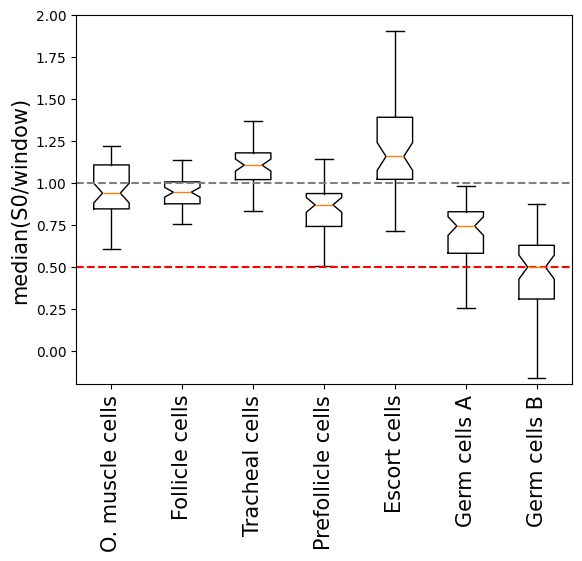

In [39]:
S0_results_final=S0_results[['seurat_clusters','S0/chr10bin0', 'S0/chr10bin1', 'S0/chr10bin2', 'S0/chr11bin0',
       'S0/chr11bin1', 'S0/chr11bin2', 'S0/chr12bin0', 'S0/chr12bin1',
       'S0/chr12bin2', 'S0/chr13bin0', 'S0/chr14bin0', 'S0/chr14bin1',
       'S0/chr15bin0', 'S0/chr15bin1', 'S0/chr16bin0', 'S0/chr16bin1',
       'S0/chr17bin0', 'S0/chr17bin1', 'S0/chr18bin0', 'S0/chr18bin1',
       'S0/chr18bin2', 'S0/chr19bin0', 'S0/chr19bin1', 'S0/chr19bin2',
       'S0/chr1bin0', 'S0/chr1bin1', 'S0/chr20bin0', 'S0/chr20bin1',
       'S0/chr21bin0', 'S0/chr21bin1', 'S0/chr2bin0', 'S0/chr2bin1',
       'S0/chr3bin0', 'S0/chr3bin1', 'S0/chr4bin0', 'S0/chr4bin1',
       'S0/chr4bin2', 'S0/chr4bin3', 'S0/chr5bin0', 'S0/chr5bin1',
       'S0/chr5bin2', 'S0/chr5bin3', 'S0/chr7bin0', 'S0/chr7bin1',
       'S0/chr8bin0', 'S0/chr8bin1', 'S0/chr8bin2', 'S0/chr9bin0',
       'S0/chr9bin1']].groupby(['seurat_clusters']).median().T
S0_results_final['adjust']=S0_results_final[[2,0,4]].mean(axis=1)
#-np.median(S0_results[S0_results['seurat_clusters'].isin([2,0,4])]['mean_all_rows_S0'])
S0_results_final[0]=S0_results_final[0]+(1-S0_results_final['adjust'])
S0_results_final[1]=S0_results_final[1]+(1-S0_results_final['adjust'])
S0_results_final[2]=S0_results_final[2]+(1-S0_results_final['adjust'])
S0_results_final[3]=S0_results_final[3]+(1-S0_results_final['adjust'])
S0_results_final[4]=S0_results_final[4]+(1-S0_results_final['adjust'])
S0_results_final[5]=S0_results_final[5]+(1-S0_results_final['adjust'])
S0_results_final[6]=S0_results_final[6]+(1-S0_results_final['adjust'])
plt.boxplot([S0_results_final[2],S0_results_final[0],S0_results_final[4],S0_results_final[5],S0_results_final[3],S0_results_final[1],S0_results_final[6]],showfliers=False,notch=True)
plt.hlines(1,0.5,7.5,color="gray",linestyle='dashed')
plt.hlines(0.5,0.5,7.5,color="red",linestyle='dashed')
plt.ylim(ymax=2)
plt.ylim(ymin=-0.2)
region = ['O. muscle cells','Follicle cells','Tracheal cells','Prefollicle cells','Escort cells','Germ cells A','Germ cells B']
plt.xticks(np.arange(1,8), region,rotation = 90,fontsize=15)
plt.ylabel('median(S0/window)',fontsize=15)
plt.savefig('/nfs/scistore18/vicosgrp/melkrewi/Project_snRNA_ovaries_with_W/8.Jupyter_notebooks_for_submission/review_figures/bootstrapping.png',bbox_inches='tight',facecolor='white',dpi=1000)